In [511]:
import esmvalcore.experimental as esmvaltool
import esmvalcore.preprocessor._regrid_esmpy as _regrid_esmpy
import esmvalcore.preprocessor._regrid as _regrid

import xarray as xr
import xesmf as xe
import numpy as np

import iris

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt

import copy

import esmvalcore.preprocessor._area as _area

# Run the recipe to have auto download

This is just an example worth about 60MB. In this model the "northpole" is moved to be over greenland. But tripolar models would present similarly in coord structure.

In [457]:
%cat recipe_download.yml

documentation:
  description: dummy
  title: dummy
  authors:
    - righi_mattia

datasets:
  - {dataset: ACCESS-ESM1-5, project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f1, grid: gn, timerange: 101/121}
  - {dataset: CESM2,         project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f1, grid: gn, timerange: 1/21}
  - {dataset: CanESM5,       project: CMIP6, exp: 1pctCO2, ensemble: r1i1p2f1, grid: gn, timerange: 1850/1870}
  - {dataset: GISS-E2-1-G-CC,   project: CMIP6, exp: esm-1pctCO2, ensemble: r1i1p1f1, grid: gn, timerange: 1850/1870}
  - {dataset: MIROC-ES2L,    project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f2, grid: gn, timerange: 1850/1870}
  - {dataset: MPI-ESM1-2-LR, project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f1, grid: gn, timerange: 1850/1870}
  - {dataset: NorESM2-LM,    project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f1, grid: gn, timerange: 1/21}
  - {dataset: UKESM1-0-LL,   project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f2, grid: gn, timerange: 1850/1870}

preprocessors:
  pp_fgco

In [595]:
recipe = esmvaltool.Recipe("recipe_download.yml")
output = recipe.run()

/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'cell index along second dimension'.
  warnings.warn(msg.format(self.name()))
/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'cell index along first dimension'.
  warnings.warn(msg.format(self.name()))
/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/coords.py:1976: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/coords.py:1976: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [596]:
taskoutput = output["download/fgco2"]
datafile = taskoutput.data_files[1]
datafile

DataFile('CMIP6_MIROC-ES2L_Omon_1pctCO2_r1i1p1f2_fgco2_gn_1850-1870.nc')

In [597]:
output

download/fgco2:
  DataFile('CMIP6_MPI-ESM1-2-LR_Omon_1pctCO2_r1i1p1f1_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_MIROC-ES2L_Omon_1pctCO2_r1i1p1f2_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_GISS-E2-1-G-CC_Omon_esm-1pctCO2_r1i1p1f1_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_CanESM5_Omon_1pctCO2_r1i1p2f1_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_ACCESS-ESM1-5_Omon_1pctCO2_r1i1p1f1_fgco2_gn_0101-0121.nc')
  DataFile('CMIP6_NorESM2-LM_Omon_1pctCO2_r1i1p1f1_fgco2_gn_0001-0021.nc')
  DataFile('CMIP6_UKESM1-0-LL_Omon_1pctCO2_r1i1p1f2_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_CESM2_Omon_1pctCO2_r1i1p1f1_fgco2_gn_0001-0021.nc')

download/fgco2_area_sum:
  DataFile('CMIP6_NorESM2-LM_Omon_1pctCO2_r1i1p1f1_fgco2_gn_0001-0021.nc')
  DataFile('CMIP6_MPI-ESM1-2-LR_Omon_1pctCO2_r1i1p1f1_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_MIROC-ES2L_Omon_1pctCO2_r1i1p1f2_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_CanESM5_Omon_1pctCO2_r1i1p2f1_fgco2_gn_1850-1870.nc')
  DataFile('CMIP6_ACCESS-ESM1-5_Omon_1pctCO2_r1i1p1

In [598]:
cubes = {datafile.load_iris().concatenate_cube().attributes["source_id"]:datafile.load_iris().concatenate_cube() for datafile in output["download/fgco2"].data_files}

In [599]:
cubes_area_sum = {datafile.load_iris().concatenate_cube().attributes["source_id"]:datafile.load_iris().concatenate_cube() for datafile in output["download/fgco2_area_sum"].data_files}

## Load example data as iris.Cube and xarray.DataSet

In [292]:
cube.attributes["source_id"]

'GISS-E2-1-G-CC'

In [259]:
cube = datafile.load_iris().concatenate_cube()
xrds = datafile.load_xarray()
cube.coord("longitude").is_contiguous()

True

Define target Cube/Dataset with regular rectilinear grids

In [7]:
cube_target = _regrid._global_stock_cube("1x1") # LONxLAT

In [8]:
xrds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1)),
        "lon": (["lon"], np.arange(0, 360, 1)),
    }
)

In [9]:
cube_target.shape

(180, 360)

In [10]:
xrds_target.dims

Frozen({'lat': 180, 'lon': 360})

# 0. First attempt with iris builtin regridding and the PointInCell scheme is not working.

Why does it require a CRS?

In [10]:
cube.regrid(cube_target, scheme=iris.analysis.PointInCell())

ValueError: The source X and Y coordinates must have a defined coordinate system.

# 0.1 What if we assume WGS84 like in iris.cartography.project?

In [48]:
wgs84 = iris.coord_systems.GeogCS(semi_major_axis=6378137.0, inverse_flattening=298.257223563)

In [49]:
cube.coord_system = wgs84
cube.coord(axis="x").coord_system = wgs84
cube.coord(axis="y").coord_system = wgs84

cube_target.coord_system = wgs84
cube_target.coord(axis="x").coord_system = wgs84
cube_target.coord(axis="y").coord_system = wgs84

In [50]:
cube_out = cube.regrid(cube_target, scheme=iris.analysis.PointInCell())

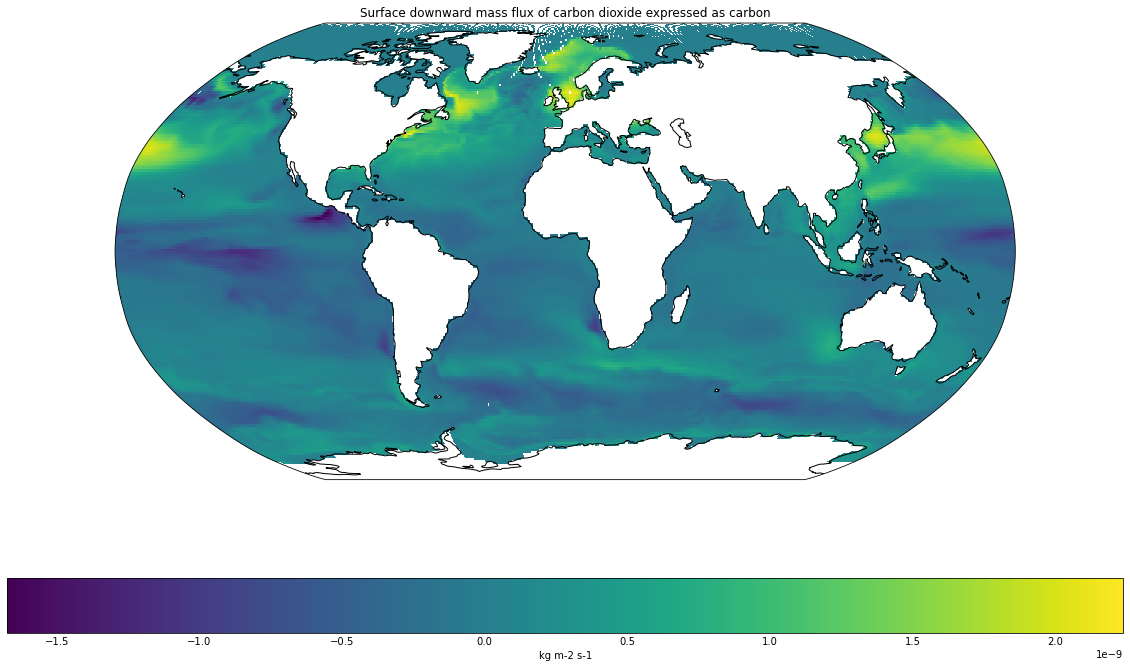

In [51]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
qplt.pcolormesh(cube_out[0])
plt.gca().coastlines()

No ;) but I guess it makes sense as there are not enough source points to the in the cell.

# 1. Builtin esmvalcore function that is also used by `regrid` preprocessor

In [52]:
cube_out = _regrid_esmpy.regrid(cube, cube_target, "linear")

In [15]:
iris.save(cube_out, "iris.nc")

### It's slow!

In [59]:
%timeit _regrid_esmpy.regrid(cube, cube_target, "linear")

18.7 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


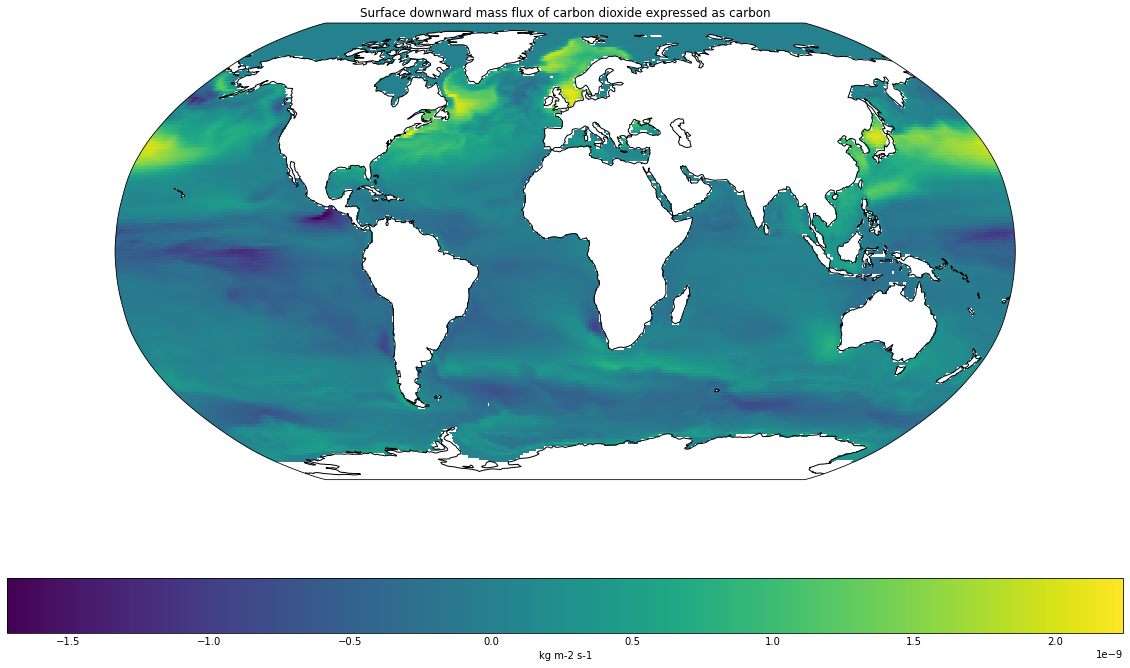

In [60]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
qplt.pcolormesh(cube_out[0])
plt.gca().coastlines()

# 2. xesmf regridding 

In [60]:
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=False)

In [61]:
xrds_out = regridder(xrds)

/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.


In [19]:
xrds_out.to_netcdf("xr.nc")

### 60x times faster on my laptop!
I believe the reason is that xesmf only computes the weights using ESMPy, but then applies them to the data with scipy sparse matrix multiplication.

In [22]:
%%timeit
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=True)
xrds_out = regridder(xrds)

/gxfs_home/geomar/smomw522/miniconda3/envs/test_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.


418 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Even without reusing the weights (which is the expensive part in xesmf) its still 10x faster. This will scale faster with more data.

In [23]:
%%timeit
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=False)
xrds_out = regridder(xrds)

2.53 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


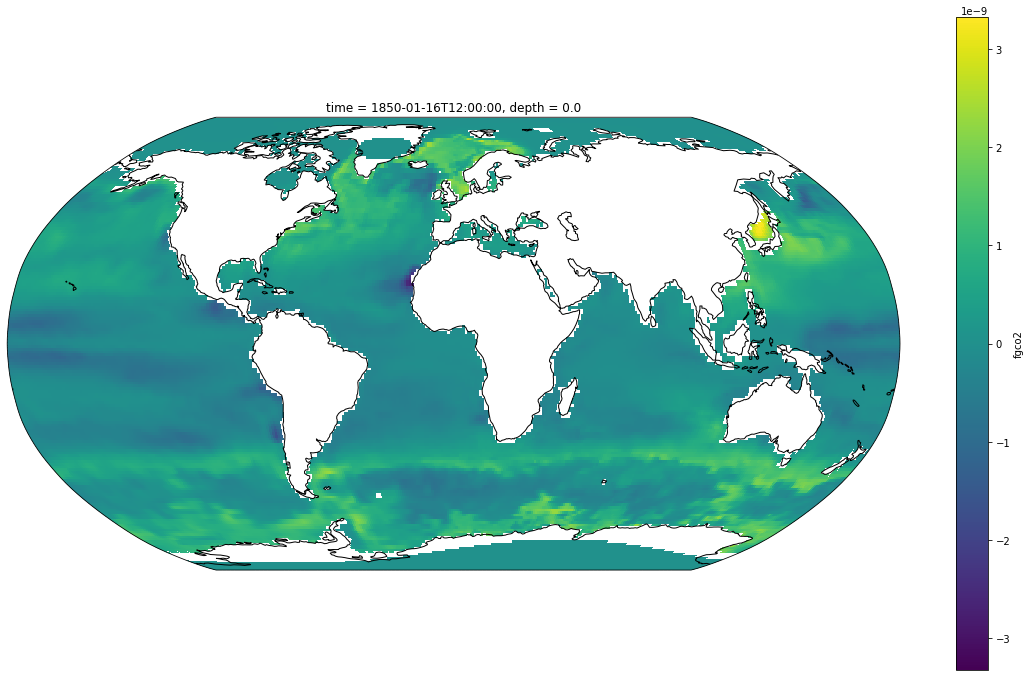

In [62]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
xrds_out.fgco2[0].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap="viridis")
ax.coastlines()

### Masking on Antarctica and Greenland (near poles) is lost.

# 3. Nearest neighbour in iris.analysis.cartography.project
Fine for plotting but not usable for computing statistics!

In [55]:
import iris.analysis.cartography

target_proj = ccrs.PlateCarree()
projected, extent = iris.analysis.cartography.project(cube, target_proj,
                                                         nx=360, ny=180)

#plt.gca().coastlines()

/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/analysis/cartography.py:633: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/analysis/cartography.py:821: UserWarning: Discarding coordinates that share dimensions with latitude and longitude: ['cell index along first dimension', 'cell index along second dimension']


/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
/Users/dhohn/mambaforge/envs/test_env2/lib/python3.8/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.


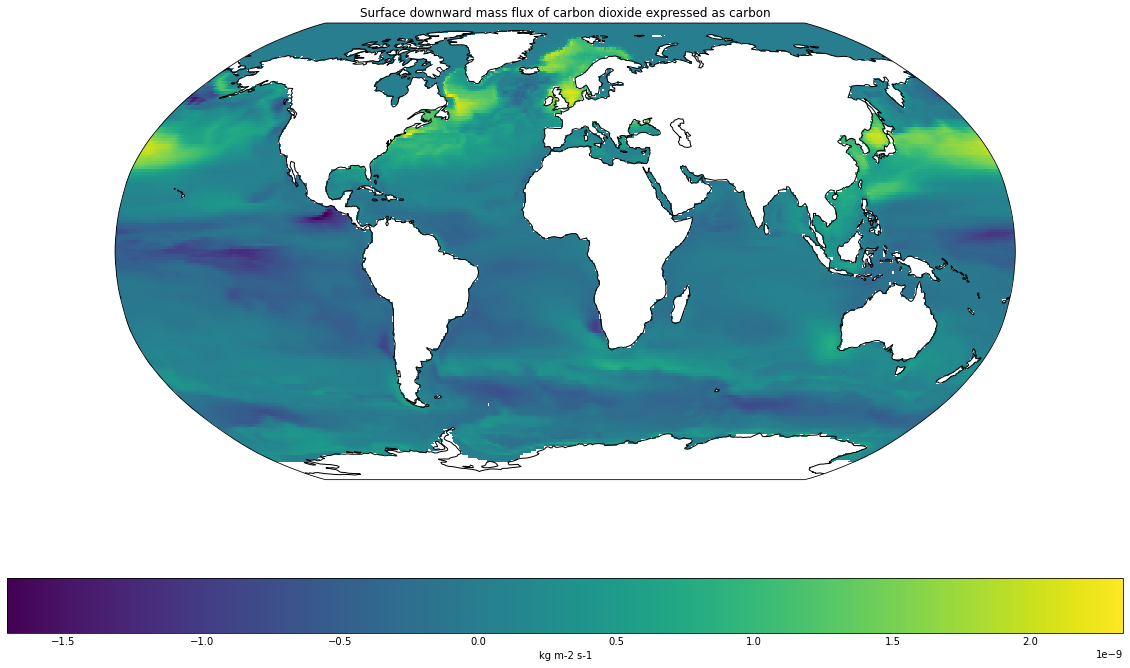

In [56]:
plt.figure(figsize=(20, 12))
plt.axes(projection=ccrs.Robinson(0))
qplt.pcolormesh(projected[0])
plt.gca().coastlines()

# 4. iris-esmf-regrid

https://github.com/SciTools-incubator/iris-esmf-regrid

needs modification here for certain models (with incorrect bounds??): https://github.com/SciTools-incubator/iris-esmf-regrid/blob/24997c7a97ad4706e3b9c010dd2ec8304cdcc153/esmf_regrid/schemes.py#L44

In [260]:
cube.data = np.ma.masked_equal(cube.data, 0.0)

In [274]:
cube.data = np.ma.filled(cube.data, 0.0)

In [262]:
cube.data.fill_value = 1e20

In [12]:
from esmf_regrid.schemes import ESMFAreaWeightedRegridder
import esmf_regrid

In [172]:
cube_out = cube.regrid(cube_target, scheme=esmf_regrid.schemes.ESMFAreaWeighted(mdtol=.0))

In [14]:
regridder = ESMFAreaWeightedRegridder(cube, cube_target)

In [15]:
regridder.regridder.tgt.crs

<Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
%timeit regridder = ESMFAreaWeightedRegridder(cube, cube_target)

7.34 s ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
cube_out = regridder(cube)

In [18]:
%timeit cube_out = regridder(cube)

1.33 ms ± 7.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
cube_out.collapsed(["latitude","longitude"], iris.analysis.MEAN)[0].data

array(2.36171204e-11)

In [309]:
t = _area.area_statistics(cubes[1][0], "sum").data

In [45]:
0.0 mean: 1.59665507e-11
0.5 mean: 2.00236509e-11
1.0 mean: 2.36171204e-11

0.0 sum: 6.57678189e-07
0.5 sum: 8.53528142e-07
1.0 sum: 1.03683882e-06

SyntaxError: invalid syntax (496405180.py, line 1)

In [55]:
import pandas as pd

In [54]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [275]:
mdtol_data = {}
for mdtol in np.linspace(0,1,11):
    cube_out = cube[0].regrid(cube_target, scheme=esmf_regrid.schemes.ESMFAreaWeighted(mdtol=mdtol))
    #mdtol_data[mdtol] = cube_out.collapsed(["latitude","longitude"], iris.analysis.MEAN).data
    mdtol_data[mdtol] = _area.area_statistics(cube_out, "sum").data

In [600]:
columns = ["model", 
            "sum_no_regrid",
            "mdtol", 
            "sum_regrid_masked",
            "cube_out_masked",
            "sum_regrid_filled",
            "cube_out_filled",
          ]
rows = []
for model, orig_cube in cubes.items():
    sum_no_regrid = cubes_area_sum[model][200].data.item()
    orig_cube.data = np.ma.masked_equal(orig_cube.data, 0.0)
    
    for mdtol in np.linspace(0,1,11):
        cube = copy.deepcopy(orig_cube)
        cube_out_masked = cube[200].regrid(cube_target, scheme=esmf_regrid.schemes.ESMFAreaWeighted(mdtol=mdtol))
        sum_regrid_masked = _area.area_statistics(cube_out_masked, "sum").data.item()
        
        cube.data = np.ma.filled(cube.data, 0.0)
        cube_out_filled = cube[200].regrid(cube_target, scheme=esmf_regrid.schemes.ESMFAreaWeighted(mdtol=mdtol))
        sum_regrid_filled = _area.area_statistics(cube_out_filled, "sum").data.item()
        
        row = [model]
        row += [sum_no_regrid]
        row += [mdtol]
        row += [sum_regrid_masked]
        row += [cube_out_masked]
        row += [sum_regrid_filled]
        row += [cube_out_filled]
        
        rows += [row]

In [601]:
df = pd.DataFrame(rows, columns=columns)

In [602]:
df["rel_diff"] = ( df["sum_regrid_masked"] - df["sum_no_regrid"] ) / df["sum_no_regrid"]

In [504]:
df_fgco2 = copy.deepcopy(df)

In [515]:
df_npp = copy.deepcopy(df)

In [593]:
df[df["model"] == "MIROC-ES2L"].iloc[5]

model                                                       MIROC-ES2L
sum_no_regrid                                                      0.0
mdtol                                                              0.5
sum_regrid_masked                                          81917.48185
cube_out_masked      surface_downward_mass_flux_of_carbon_dioxide_e...
sum_regrid_filled                                         81806.566586
cube_out_filled      surface_downward_mass_flux_of_carbon_dioxide_e...
rel_diff                                            354185356762329.25
Name: 82, dtype: object

In [594]:
df

,model,sum_no_regrid,mdtol,sum_regrid_masked,cube_out_masked,sum_regrid_filled,cube_out_filled,rel_diff
0,ACCESS-ESM1-5,2.808963e-10,0.0,101322.168774,surface_downward_mass_flux_of_carbon_dioxide_e...,101387.771129,surface_downward_mass_flux_of_carbon_dioxide_e...,3.607102e+14
1,ACCESS-ESM1-5,2.808963e-10,0.1,101471.165836,surface_downward_mass_flux_of_carbon_dioxide_e...,101387.771129,surface_downward_mass_flux_of_carbon_dioxide_e...,3.612406e+14
2,ACCESS-ESM1-5,2.808963e-10,0.2,101500.360057,surface_downward_mass_flux_of_carbon_dioxide_e...,101387.771129,surface_downward_mass_flux_of_carbon_dioxide_e...,3.613446e+14
3,ACCESS-ESM1-5,2.808963e-10,0.3,101614.411392,surface_downward_mass_flux_of_carbon_dioxide_e...,101387.771129,surface_downward_mass_flux_of_carbon_dioxide_e...,3.617506e+14
4,ACCESS-ESM1-5,2.808963e-10,0.4,101418.688463,surface_downward_mass_flux_of_carbon_dioxide_e...,101387.771129,surface_downward_mass_flux_of_carbon_dioxide_e...,3.610538e+14
...,...,...,...,...,...,...,...,...
83,MIROC-ES2L,2.312842e-10,0.6,82346.327979,surface_downward_mass_flux_of_carbon_dioxide_e...,81806.566586,surface_downward_mass_flux_of_carbon_dioxide_e...,3.560396e+14
84,MIROC-ES2L,2.312842e-10,0.7,82943.993914,surface_downward_mass_flux_of_carbon_dioxide_e...,81806.566586,surface_downward_mass_flux_of_carbon_dioxide_e...,3.586237e+14
85,MIROC-ES2L,2.312842e-10,0.8,83425.555883,surface_downward_mass_flux_of_carbon_dioxide_e...,81806.566586,surface_downward_mass_flux_of_carbon_dioxide_e...,3.607058e+14
86,MIROC-ES2L,2.312842e-10,0.9,83780.534136,surface_downward_mass_flux_of_carbon_dioxide_e...,81806.566586,surface_downward_mass_flux_of_carbon_dioxide_e...,3.622406e+14


max MPI-ESM1-2-LR 0.05902279859711878
0.5 MPI-ESM1-2-LR -0.01779236693564571
max MIROC-ES2L 0.037424522260791314
0.5 MIROC-ES2L 0.0005642122913945622
max GISS-E2-1-G-CC 0.0052836684839672535
0.5 GISS-E2-1-G-CC -0.0019429968739125756
max CanESM5 0.01418855452288506
0.5 CanESM5 0.013618349960399454
max ACCESS-ESM1-5 0.003106625919898652
0.5 ACCESS-ESM1-5 -0.0007137943930561078
max NorESM2-LM 0.027547551391858775
0.5 NorESM2-LM -0.0006755542071153403
max UKESM1-0-LL 0.01572816981844525
0.5 UKESM1-0-LL -0.0027895947327236876
max CESM2 0.03288366923975081
0.5 CESM2 0.00023916028897725966


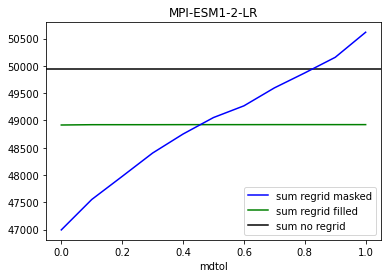

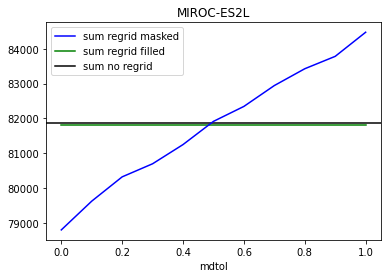

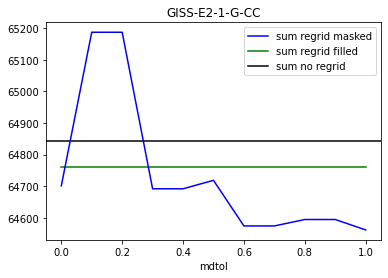

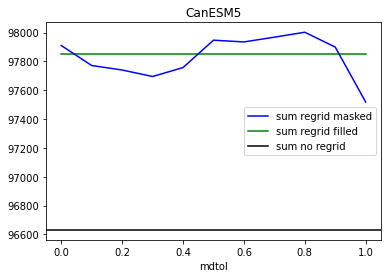

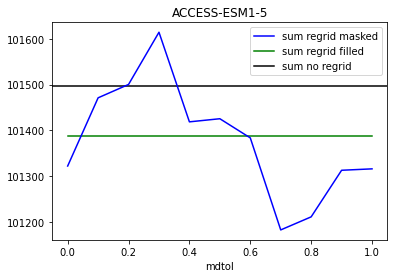

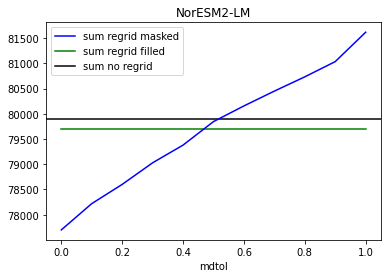

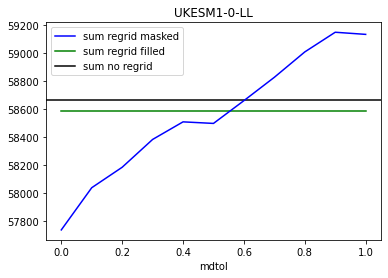

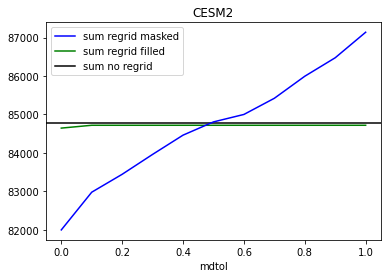

In [604]:
for model in df["model"].unique():
    model_df = df[df["model"] == model]
    ax = model_df.plot(y="sum_regrid_masked", x="mdtol", label="sum regrid masked", color="blue", zorder=10)
    model_df.plot(y="sum_regrid_filled", x="mdtol", label="sum regrid filled", color="green", ax=ax)
    plt.title(model)
    plt.axhline(model_df["sum_no_regrid"].unique(),     color="black", label="sum no regrid")
    plt.legend()
    print("max", model, np.max(np.abs(model_df["rel_diff"])))
    print("0.5", model, model_df["rel_diff"].iloc[5] )

In [367]:
import seaborn as sns

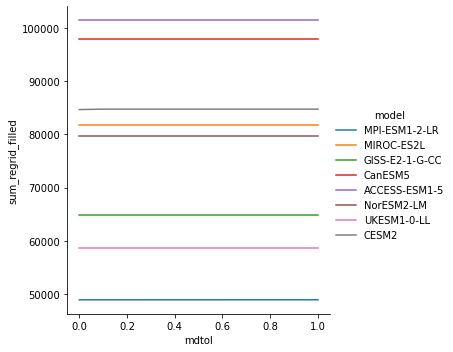

In [606]:
sns.relplot(x="mdtol", 
            y="sum_regrid_filled", 
            hue="model",
            kind="line",
            data=df)

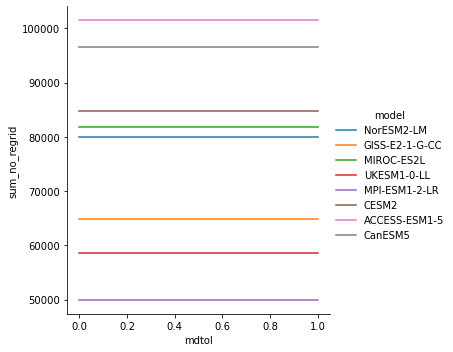

In [369]:
sns.relplot(x="mdtol", 
            y="sum_no_regrid", 
            hue="model",
            kind="line",
            data=df)

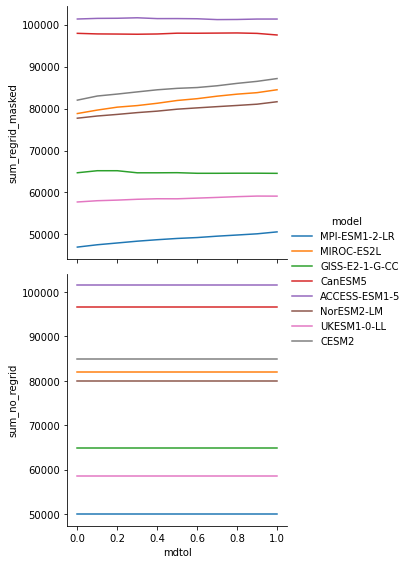

In [607]:
g = sns.PairGrid(df, y_vars=["sum_regrid_masked","sum_no_regrid"], x_vars=["mdtol"], height=4, hue="model")
g.map(sns.lineplot)
g.add_legend()
#g.set(ylim=(-1, 11), yticks=[0, 5, 10])

# UKESM

0.05502974

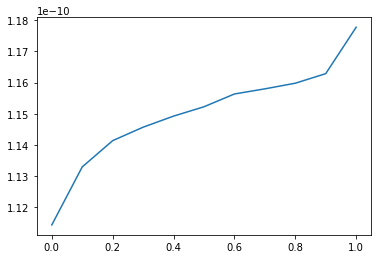

In [192]:
plt.plot(mdtol_data.keys(), mdtol_data.values())
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

# GISS

0.0

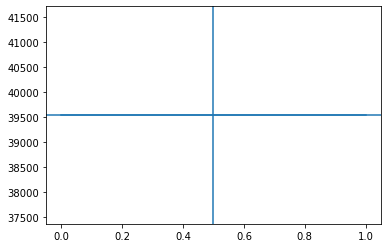

In [276]:
fig, ax = plt.subplots()
ax.plot(mdtol_data.keys(), mdtol_data.values())
ax.axhline(_area.area_statistics(cube[0], "sum").data)
ax.axvline(0.5)
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

In [277]:
np.mean(list(mdtol_data.values()))

39532.17893382563

In [272]:
_area.area_statistics(cube[0], "sum").data

array(39534.48, dtype=float32)

# MPI

0.067676775

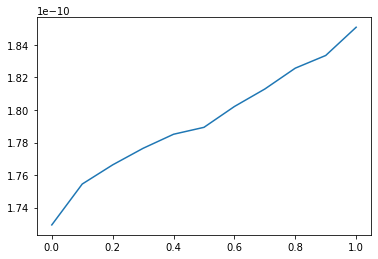

In [110]:
plt.plot(mdtol_data.keys(), mdtol_data.values())
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

# MIROC

0.5475536686748146

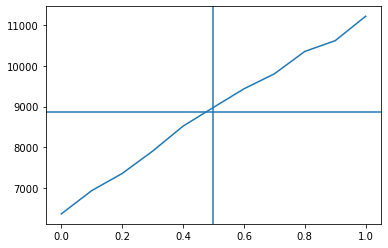

In [256]:
fig, ax = plt.subplots()
ax.plot(mdtol_data.keys(), mdtol_data.values())
ax.axhline(np.mean(list(mdtol_data.values())))
ax.axvline(0.5)
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

In [240]:
np.mean(list(mdtol_data.values()))

8859.955499628804

# CanESM

-3.703995

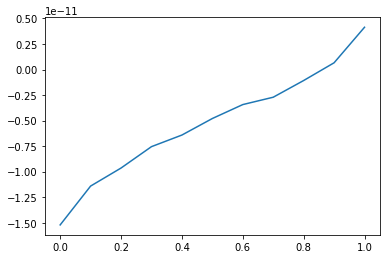

In [123]:
plt.plot(mdtol_data.keys(), mdtol_data.values())
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

# ACCESS

-0.4768077

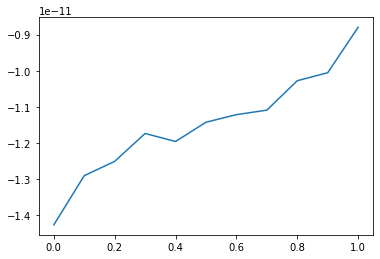

In [197]:
plt.plot(mdtol_data.keys(), mdtol_data.values())
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

# NorESM

0.21910353

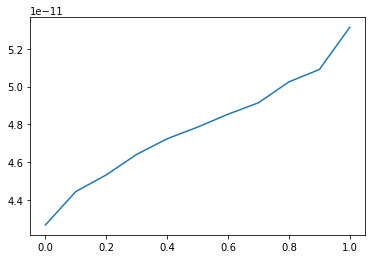

In [134]:
plt.plot(mdtol_data.keys(), mdtol_data.values())
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

# CESM

2.7549815

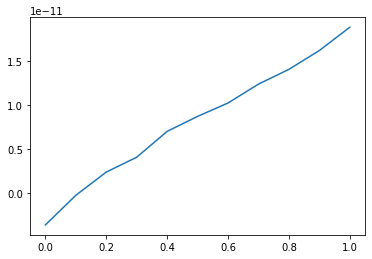

In [155]:
plt.plot(mdtol_data.keys(), mdtol_data.values())
(max(mdtol_data.values())-min(mdtol_data.values()))/np.mean(list(mdtol_data.values()))

In [469]:
my_cube = df[df["model"] == "MPI-ESM1-2-LR"][df["mdtol"] == 0.0]["cube_out_filled"].item()
my_cube2 = df[df["model"] == "MPI-ESM1-2-LR"][df["mdtol"] == 1.0]["cube_out_filled"].item()
my_cube3 = df[df["model"] == "MPI-ESM1-2-LR"][df["mdtol"] == 0.0]["cube_out_masked"].item()
my_cube4 = df[df["model"] == "MPI-ESM1-2-LR"][df["mdtol"] == 1.0]["cube_out_masked"].item()

/var/folders/r6/w4v6nnfd0gv3vpllxknpxkz90vhlct/T/ipykernel_32179/839034914.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/r6/w4v6nnfd0gv3vpllxknpxkz90vhlct/T/ipykernel_32179/839034914.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/r6/w4v6nnfd0gv3vpllxknpxkz90vhlct/T/ipykernel_32179/839034914.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/var/folders/r6/w4v6nnfd0gv3vpllxknpxkz90vhlct/T/ipykernel_32179/839034914.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


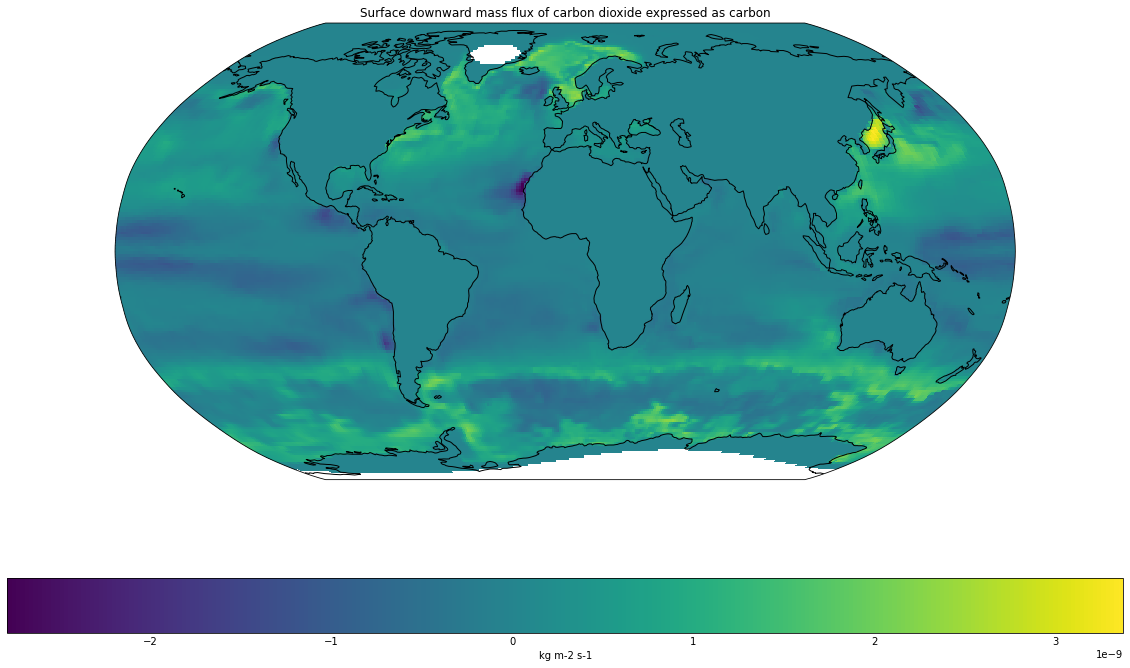

In [481]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
#qplt.pcolormesh(list(cubes.values())[0][0])
#qplt.pcolormesh(cube_out_filled)
qplt.pcolormesh(my_cube4)
plt.gca().coastlines()

In [234]:
cube.data

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

In [17]:
iris.util.find_discontiguities(cube)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [230]:
lon.bounds[:,1:-1,3]

masked_array(
  data=[[312.215  , 311.7963 , 311.38782, ..., 313.52866, 313.08163,
         312.64362],
        [311.96075, 311.5296 , 311.10925, ..., 313.3147 , 312.85376,
         312.40228],
        [311.69626, 311.25226, 310.81964, ..., 313.09186, 312.61652,
         312.15115],
        ...,
        [136.0619 , 137.34581, 138.64206, ..., 132.27979, 133.52933,
         134.78987],
        [135.40419, 136.67653, 137.96123, ..., 131.65671, 132.8947 ,
         134.14374],
        [134.73444, 135.99474, 137.26733, ..., 131.02286, 132.24898,
         133.48601]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [231]:
lon.bounds[:,2:,0]

masked_array(
  data=[[312.215  , 311.7963 , 311.38782, ..., 313.52866, 313.08163,
         312.64362],
        [311.96075, 311.5296 , 311.10925, ..., 313.3147 , 312.85376,
         312.40228],
        [311.69626, 311.25226, 310.81964, ..., 313.09186, 312.61652,
         312.15115],
        ...,
        [136.0619 , 137.34581, 138.64206, ..., 132.27979, 133.52933,
         134.78987],
        [135.40419, 136.67653, 137.96123, ..., 131.65671, 132.8947 ,
         134.14374],
        [134.73444, 135.99474, 137.26733, ..., 131.02286, 132.24898,
         133.48601]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [16]:
lon = cube.coord("longitude")
lon.bounds = lon.bounds.astype(np.float32)
atol = 1e-8; rtol = 1e-5;
def mod360_adjust(compare_axis):
    bounds = lon.bounds.copy()

    if compare_axis == "x":
        upper_bounds = bounds[:, 1:-1, 3]
        lower_bounds = bounds[:, 2:, 0]
    elif compare_axis == "y":
        upper_bounds = bounds[:-1, :, 1]
        lower_bounds = bounds[1:, :, 0]

    if lon.name() in ["longitude", "grid_longitude"]:
        # If longitude, adjust for longitude wrapping
        diffs = upper_bounds - lower_bounds
        index = diffs > 180
        if index.any():
            print("mod")
            sign = np.sign(diffs)
            modification = (index.astype(int) * 360) * sign
            upper_bounds -= modification

    diffs_between_cells = np.abs(upper_bounds - lower_bounds)
    print(f"{diffs_between_cells=}")
    
    cell_size = np.abs(lower_bounds - upper_bounds)
    print(f"{cell_size=}")
    
    diffs_along_axis = diffs_between_cells > (atol + rtol * cell_size)
    print(f"{diffs_along_axis=}")
    
    points_close_enough = diffs_along_axis <= (atol + rtol * cell_size)
    print(f"{points_close_enough=}")
    
    contiguous_along_axis = np.all(points_close_enough)
    return diffs_along_axis, contiguous_along_axis

diffs_along_x, match_cell_x1 = mod360_adjust(compare_axis="x")
diffs_along_y, match_cell_y1 = mod360_adjust(compare_axis="y")

contiguous = match_cell_x1 and match_cell_y1
diffs = (diffs_along_x, diffs_along_y)


mod
diffs_between_cells=masked_array(
  data=[[1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
        ...,
        [0.13070297241210938, 0.16345977783203125, 0.19631195068359375,
         ..., 0.032283782958984375, 0.000274658203125,
         0.032833099365234375],
        [0.09813690185546875, 0.13092422485351562, 0.163787841796875,
         ..., 0.06529998779296875, 0.032611846923828125,
         5.340576171875e-05],
        [0.06546401977539062, 0.09824752807617188, 0.1310882568359375,
         ..., 0.09824752807617188, 0.06546401977539062,
         0.03272247314453125]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False,

In [18]:
lon.contiguous_bounds()

array([[60.        , 61.        , 62.        , ..., 58.        ,
        59.        , 60.        ],
       [60.        , 61.        , 62.        , ..., 58.        ,
        59.        , 60.        ],
       [60.        , 61.        , 62.        , ..., 58.        ,
        59.        , 60.        ],
       ...,
       [60.        , 60.06541061, 60.13085938, ..., 59.86914062,
        59.93458939, 60.        ],
       [60.        , 60.03272247, 60.06546402, ..., 59.93453598,
        59.96727753, 60.        ],
       [60.        , 60.        , 60.        , ..., 60.        ,
        60.        , 60.        ]])

In [19]:
lon._discontiguity_in_bounds()

(True,
 (masked_array(
    data=[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
    mask=False,
    fill_value=True),
  masked_array(
    data=[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
    mask=False,
    fill_value=True)))

In [98]:
conti, diffs = cube.coord("longitude")._discontiguity_in_bounds()
conti

True

In [21]:
diffs_x, diffs_y = diffs

Text(0, 0.5, 'lat')

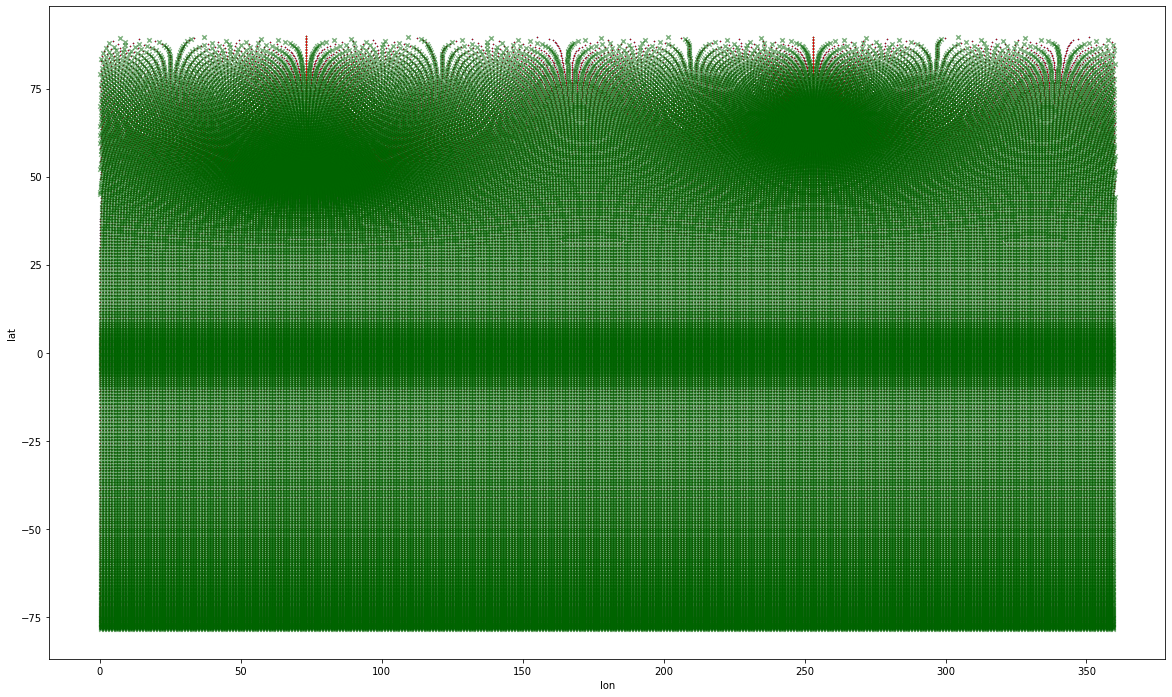

In [124]:
plt.figure(figsize=(20, 12))
plt.scatter(cube.coord("longitude").bounds[:,:,3], cube.coord("latitude").bounds[:,:,3], s=0.1, c="green")  # plot grid locations
plt.scatter(cube.coord("longitude").bounds[:,:,2], cube.coord("latitude").bounds[:,:,2], s=0.1, c="blue")  # plot grid locations
plt.scatter(cube.coord("longitude").bounds[:,:,1], cube.coord("latitude").bounds[:,:,1], s=0.1, c="black")  # plot grid locations
plt.scatter(cube.coord("longitude").bounds[:,:,0], cube.coord("latitude").bounds[:,:,0], s=0.1, c="red")  # plot grid locations

plt.scatter(cube.coord("longitude").points, cube.coord("latitude").points, s=20, alpha=0.5, c="darkgreen", marker="x")  # plot grid locations




#plt.ylim([65, 67])
#plt.xlim([251, 255])
plt.xlabel("lon")
plt.ylabel("lat")

# Other unexplored options

1. [Cartopy img_transform](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.img_transform.regrid.html#cartopy.img_transform.regrid) as used in the [monitor diagnostic](https://github.com/ESMValGroup/ESMValTool/blob/main/esmvaltool/diag_scripts/monitor/monitor.py) and [mapgenerator](https://pypi.org/project/mapgenerator/) ([source](https://earth.bsc.es/gitlab/es/mapgenerator/-/blob/master/mapgenerator/plotting/definitions.py#L72) unfortunately completely undocumented...)

### Playing with the data (stop reading ;):

In [ ]:
projected.coords()

In [ ]:
regridder.weights.data

In [ ]:
xrds['fgco2'].values.flags

In [ ]:
cube.data.flags

In [ ]:
iris.analysis.maths.apply_ufunc(xe.Regridder.regrid_array, cube, regridder.weights.data)

In [ ]:
xe.Regridder.regrid_array

In [ ]:
regridder.regrid_array(cube.data, regridder.weights.data)

In [ ]:
cube.data.fill_value

In [ ]:
xcoord = cube.coord(axis="x")

In [ ]:
cube.coord_dims(xcoord)

In [ ]:
cube_out.coord(axis="x").shape

In [ ]:
xrds.nbytes/1024/1024

In [117]:
cube = iris.load_cube("/Users/dhohn/climate_data/CMIP6/CMIP/NCC/NorESM2-LM/1pctCO2/r1i1p1f1/SImon/siconc/gn/v20190815/siconc_SImon_NorESM2-LM_1pctCO2_r1i1p1f1_gn_000101-001012.nc")

/Users/dhohn/mambaforge/envs/esmvaltool/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'siconc'


In [118]:
p1 = cube.coord("latitude").points
b1 = cube.coord("latitude").bounds

In [119]:
cube = iris.load_cube("~/climate_data/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/SImon/siconc/gn/v20191108/siconc_SImon_NorESM2-LM_esm-1pct-brch-1000PgC_r1i1p1f1_gn_014701-015612.nc")

/Users/dhohn/mambaforge/envs/esmvaltool/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'siconc'


In [120]:
p2 = cube.coord("latitude").points
b2 = cube.coord("latitude").bounds

In [137]:
p1 = np.ma.masked_greater(p1, p1.fill_value)
p2 = np.ma.masked_greater(p2, p2.fill_value)
b1.mask = p1.mask
b2.mask = p2.mask

In [134]:
with numpy.printoptions(threshold=numpy.inf):
    print(b2)

[[[-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- -- -- --]
  [-- --

In [130]:
np.ma.flatnotmasked_edges(b1)

array([  2940, 552923])